# Fermi-LAT data with Gammapy

## Introduction

This tutorial will show you how to work with Fermi-LAT data with Gammapy. As an example, we will look at the Galactic center region using the high-energy dataset that was used for the 3FHL catalog, in the energy range 10 GeV to 2 TeV.

We note that support for Fermi-LAT data analysis in Gammapy is very limited. For most tasks, we recommend you use 
[Fermipy](http://fermipy.readthedocs.io/), which is based on the [Fermi Science Tools](https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/) (Fermi ST).

Using Gammapy with Fermi-LAT data could be an option for you if you want to do an analysis that is not easily possible with Fermipy and the Fermi Science Tools. For example a joint likelihood fit of Fermi-LAT data with data e.g. from H.E.S.S., MAGIC, VERITAS or some other instrument, or analysis of Fermi-LAT data with a complex spatial or spectral model that is not available in Fermipy or the Fermi ST.

Besides Gammapy, you might want to look at are [Sherpa](http://cxc.harvard.edu/sherpa/) or [3ML](https://threeml.readthedocs.io/). Or just using Python to roll your own analyis using several existing analysis packages. E.g. it it possible to use Fermipy and the Fermi ST to evaluate the likelihood on Fermi-LAT data, and Gammapy to evaluate it e.g. for IACT data, and to do a joint likelihood fit using e.g. [iminuit](http://iminuit.readthedocs.io/) or [emcee](http://dfm.io/emcee).

To use Fermi-LAT data with Gammapy, you first have to use the Fermi ST to prepare an event list (using ``gtselect`` and ``gtmktime``, exposure cube (using ``gtexpcube2`` and PSF (using ``gtpsf``). You can then use [gammapy.data.EventList](http://docs.gammapy.org/dev/api/gammapy.data.EventList.html), [gammapy.maps](http://docs.gammapy.org/dev/maps/) and the [gammapy.irf.EnergyDependentTablePSF](http://docs.gammapy.org/dev/api/gammapy.irf.EnergyDependentTablePSF.html) to read the Fermi-LAT maps and PSF, i.e. support for these high-level analysis products from the Fermi ST is built in. To do a 3D map analyis, you can use [MapFit](http://docs.gammapy.org/dev/api/gammapy.cube.MapFit.html) for Fermi-LAT data in the same way that it's use for IACT data. This is illustrated in this notebook. A 1D region-based spectral analysis is also possible, this will be illustrated in a future tutorial. There you have to extract 1D counts, exposure and background vectors and then pass them to [SpectrumFit](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumFit.html).

## Setup

**IMPORTANT**: For this notebook you have to get the prepared ``3fhl`` dataset provided in the [gammapy-fermi-lat-data](https://github.com/gammapy/gammapy-fermi-lat-data) repository. Please follow the instructions [here](https://github.com/gammapy/gammapy-fermi-lat-data#get-the-data) to download the data and setup your environment.

Note that the ``3fhl`` dataset is high-energy only, ranging from 10 GeV to 2 TeV.

In [1]:
# Check that you have the prepared Fermi-LAT dataset
!ls -1 $GAMMAPY_FERMI_LAT_DATA/3fhl

README.md
background_norm
fermi_3fhl_counts_cube_hpx.fits.gz
fermi_3fhl_data_config.yaml
fermi_3fhl_data_prepare.sh
fermi_3fhl_events.fits.gz
fermi_3fhl_events_selected.fits.gz
fermi_3fhl_exposure_cube_hpx.fits.gz
fermi_3fhl_livetime.fits.gz
fermi_3fhl_psf_gc.fits.gz


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from gammapy.data import EventList
from gammapy.irf import EnergyDependentTablePSF
from gammapy.maps import Map, WcsNDMap, MapAxis

## Events

To load up the Fermi-LAT event list, use the [gammapy.data.EventList](http://docs.gammapy.org/dev/api/gammapy.data.EventList.html) class:

In [4]:
events = EventList.read('$GAMMAPY_FERMI_LAT_DATA/3fhl/fermi_3fhl_events_selected.fits.gz')
print(events)

EventList info:
- Number of events: 697317
- Median energy: 15895.3505859375 MeV



The event data is stored in a [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html) object. In case of the Fermi-LAT event list this contains all the additional information on positon, zenith angle, earth azimuth angle, event class, event type etc.

In [5]:
events.table.colnames

['ENERGY',
 'RA',
 'DEC',
 'L',
 'B',
 'THETA',
 'PHI',
 'ZENITH_ANGLE',
 'EARTH_AZIMUTH_ANGLE',
 'TIME',
 'EVENT_ID',
 'RUN_ID',
 'RECON_VERSION',
 'CALIB_VERSION',
 'EVENT_CLASS',
 'EVENT_TYPE',
 'CONVERSION_TYPE',
 'LIVETIME',
 'DIFRSP0',
 'DIFRSP1',
 'DIFRSP2',
 'DIFRSP3',
 'DIFRSP4']

In [6]:
events.table[:5][['ENERGY', 'RA', 'DEC']]

ENERGY,RA,DEC
MeV,deg,deg
float32,float32,float32
12856.5205,139.64438,-9.93702
14773.319,177.04454,60.55275
23273.527,110.21325,37.002018
41866.125,334.85287,17.577398
42463.074,316.86676,48.152477


In [7]:
print(events.time[0].iso)
print(events.time[-1].iso)

2008-08-04 15:49:26.782
2015-07-30 11:00:41.226


In [8]:
events.energy.info('stats')

mean = 28905.451171875 MeV
std = 61051.7421875 MeV
min = 10000.03125 MeV
max = 1998482.75 MeV
n_bad = 0
length = 697317


As a short analysis example we will count the number of events above a certain minimum energy: 

In [9]:
for e_min in [10, 100, 1000] * u.GeV:
    n = (events.energy > e_min).sum()
    print("Events above {0:4.0f}: {1:5.0f}".format(e_min, n))

Events above   10 GeV: 697317
Events above  100 GeV: 23628
Events above 1000 GeV:   544


## Counts

Let us start to prepare things for an 3D map analysis of the Galactic center region with Gammapy. The first thing we do is to define the map geometry. We chose a TAN projection centered on position ``(glon, glat) = (0, 0)`` with pixel size 0.1 deg, and four energy bins.

In [10]:
gc_pos = SkyCoord(0, 0, unit='deg', frame='galactic')
energy_axis = MapAxis.from_edges(
    [10, 30, 100, 300, 2000],
    name='energy', unit='GeV', interp='log',
)
counts = Map.create(
    skydir=gc_pos,
    npix=(100, 80),
    proj='TAN',
    coordsys='GAL',
    binsz=0.1,
    axes=[energy_axis],
)
# We put this call into the same Jupyter cell as the Map.create
# because otherwise we could accidentally fill the counts
# multiple times when executing the ``fill_by_coord`` multiple times.
counts.fill_by_coord({
    'skycoord': events.radec,
    # The coord-based interface doesn't use Quantity,
    # so we need to pass energy in the same unit as
    # used for the map axis
    'energy': events.energy.to('GeV').value,
})

In [11]:
counts.geom.axes[0]

MapAxis

	name     : energy
	type     : energy
	unit     : GeV
	nbins    : 4
	node type: edge
	edge min : 1.0e+01 GeV
	edge max : 2.0e+03 GeV
	interp   : log

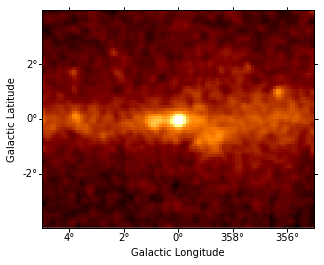

In [12]:
counts.sum_over_axes().smooth(2).plot(stretch='sqrt', vmax=30);

## Exposure

The Fermi-LAT datatset contains the energy-dependent exposure for the whole sky as a HEALPix map computed with ``gtexpcube2``. This format is supported by ``gammapy.maps`` directly.

Interpolating the exposure cube from the Fermi ST to get an exposure cube matching the spatial geometry and energy axis defined above with Gammapy is easy. The only point to watch out for is how exactly you want the energy axis and binning handled.

Below we just use the default behaviour, which is linear interpolation in energy on the original exposure cube. Probably log interpolation would be better, but it doesn't matter much here, because the energy binning is fine. Finally, we just copy the counts map geometry, which contains an energy axis with `node_type="edges"`. This is non-ideal for exposure cubes, but again, acceptable because exposure doesn't vary much from bin to bin, so the exact way interpolation occurs in later use of that exposure cube doesn't matter a lot. Of course you could define any energy axis for your exposure cube that you like.

In [21]:
exposure_hpx = Map.read('$GAMMAPY_FERMI_LAT_DATA/3fhl/fermi_3fhl_exposure_cube_hpx.fits.gz')
# Unit is not stored in the file, set it manually
exposure_hpx.unit = 'cm2 s'
print(exposure_hpx.geom)
print(exposure_hpx.geom.axes[0])

HpxGeom

	npix      : 12288 pix
	nside     : 32
	nested    : False
	coordsys  : CEL
	projection: HPX
	center    : 0.0 deg, 0.0 deg
	ndim      : 3
	axes      : energy

MapAxis

	name     : energy
	type     : any
	unit     : 
	nbins    : 18
	node type: center
	edge min : 8.2e+03 
	edge max : 2.3e+06 
	interp   : lin



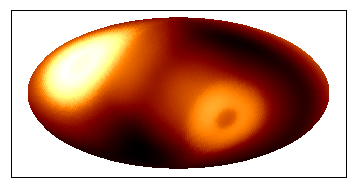

In [17]:
exposure_hpx.plot();

In [18]:
# We need to manually adjust the energy coord unit,
# which is MeV in the HPX exposure cube and GeV in our geom
coord = counts.geom.get_coord()
data = exposure_hpx.interp_by_coord({
    'skycoord': coord.skycoord,
    'energy': 1000 * coord['energy'],
})
exposure = WcsNDMap(counts.geom, data, unit=exposure_hpx.unit)

print(exposure.geom)
print(exposure.geom.axes[0])

WcsGeom

	npix      : 100 x 80 pix
	coordsys  : GAL
	projection: TAN
	center    : 0.0 deg, 0.0 deg
	width     : 10.0 x 8.0 deg
	ndim      : 3
	axes      : energy

MapAxis

	name     : energy
	type     : energy
	unit     : GeV
	nbins    : 4
	node type: edge
	edge min : 1.0e+01 GeV
	edge max : 2.0e+03 GeV
	interp   : log



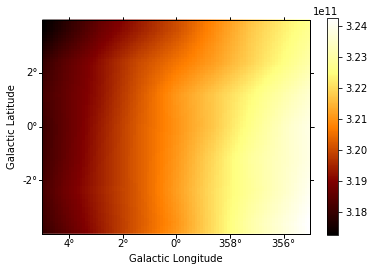

In [19]:
# Exposure is almost constant accross the field of view
exposure.slice_by_idx({'energy': 0}).plot(add_cbar=True);

In [20]:
# Exposure varies very little with energy at these high energies
energy = [10, 100, 1000] * u.GeV
exposure.get_by_coord({
    'skycoord': gc_pos,
    'energy': energy,
})

array([3.21027571e+11, 3.27555383e+11, 3.02893154e+11])

## Galactic diffuse background

The Fermi-LAT collaboration provides a galactic diffuse emission model, that can be used as a background model for
Fermi-LAT source analysis.

We are adding this as a Gammapy model class at the moment, so that you will be able to fit the norm of that model component (see [Github issue 1634](https://github.com/gammapy/gammapy/pull/1634)). For now, you can just read the diffuse emission map and manually compute a background map from it, that contains the number of expected background counts per bin.

Diffuse model maps are very large (100s of MB), so as an example here, we just load one that represents a small cutout for the Galactic center region.

In [22]:
diffuse_galactic_fermi = Map.read('$GAMMAPY_EXTRA/test_datasets/unbundled/fermi/gll_iem_v02_cutout.fits')
# Unit is not stored in the file, set it manually
diffuse_galactic_fermi.unit = 'cm-2 s-1 MeV-1 sr-1'
print(diffuse_galactic_fermi.geom)
print(diffuse_galactic_fermi.geom.axes[0])

WcsGeom

	npix      : 61 x 21 pix
	coordsys  : GAL
	projection: CAR
	center    : 359.8 deg, -0.2 deg
	width     : 30.5 x 10.5 deg
	ndim      : 3
	axes      : energy

MapAxis

	name     : energy
	type     : energy
	unit     : MeV
	nbins    : 30
	node type: center
	edge min : 4.3e+01 MeV
	edge max : 1.1e+05 MeV
	interp   : lin



In [23]:
# Interpolate the diffuse emission model onto the counts geometry
# The resolution of `diffuse_galactic_fermi` is low: bin size = 0.5 deg
# We use ``interp=3`` which means cubic spline interpolation
coord = counts.geom.get_coord()
data = diffuse_galactic_fermi.interp_by_coord({
    'skycoord': coord.skycoord,
    'energy': 1000 * coord['energy'],
}, interp=3)
diffuse_galactic = WcsNDMap(counts.geom, data, unit=diffuse_galactic_fermi.unit)

print(diffuse_galactic.geom)
print(diffuse_galactic.geom.axes[0])

WcsGeom

	npix      : 100 x 80 pix
	coordsys  : GAL
	projection: TAN
	center    : 0.0 deg, 0.0 deg
	width     : 10.0 x 8.0 deg
	ndim      : 3
	axes      : energy

MapAxis

	name     : energy
	type     : energy
	unit     : GeV
	nbins    : 4
	node type: edge
	edge min : 1.0e+01 GeV
	edge max : 2.0e+03 GeV
	interp   : log



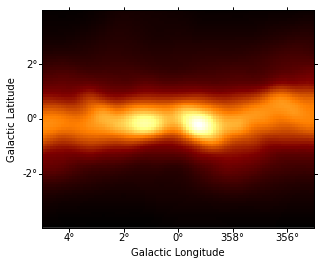

In [24]:
diffuse_galactic.slice_by_idx({'energy': 0}).plot();

Text(0,0.5,'Flux (cm-2 s-1 MeV-1 sr-1)')

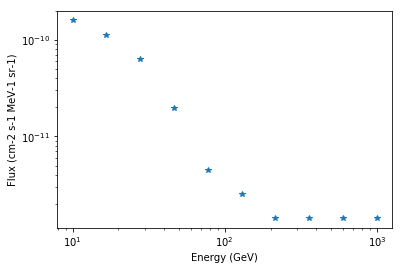

In [29]:
# Exposure varies very little with energy at these high energies
energy = np.logspace(1, 3, 10) * u.GeV
dnde = diffuse_galactic.interp_by_coord({
    'skycoord': gc_pos,
    'energy': energy,
}, interp='linear')
plt.plot(energy.value, dnde, '*')
plt.loglog()
plt.xlabel('Energy (GeV)')
plt.ylabel('Flux (cm-2 s-1 MeV-1 sr-1)')

In [30]:
# TODO: show how one can fix the extrapolate to high energy
# by computing and padding an extra plane e.g. at 1e3 TeV
# that corresponds to a linear extrapolation

Again you can use the slider to slide through the different energy bands. E.g. note how the Fermi-Bubbles become more present at higher energies (higher value of idx).

## Isotropic diffuse background

Additionally to the galactic diffuse model, there is an isotropic diffuse component. It can be accessed by the `dataset.isotropic_diffuse` property and returns an instance of the Gammapy [gammapy.spectrum.models.TableModel](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.TableModel.html#gammapy.spectrum.models.TableModel) class:

In [16]:
isotropic_diffuse = dataset.isotropic_diffuse
print(isotropic_diffuse)

TableModel
ParameterList
Parameter(name='amplitude', value=1, unit='', min=0, max=None, frozen=False)

Covariance: None


We can plot the model in the energy range between 50 GeV and 2000 GeV:

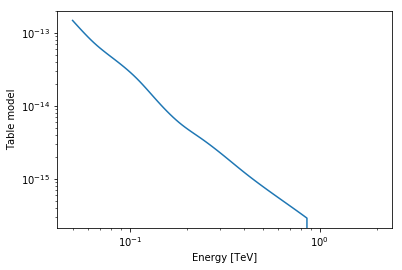

In [17]:
erange = [50, 2000] * u.GeV
isotropic_diffuse.plot(erange)

## PSF

Next we will tke a look at the PSF. It was computed using ``gtpsf``, in this case for the Galactic center position. Note that generally for Fermi-LAT, the PSF only varies little within a given regions of the sky, especially at high energies like what we have here. We use the [gammapy.irf.EnergyDependentTablePSF](http://docs.gammapy.org/dev/api/gammapy.irf.EnergyDependentTablePSF.html) class to load the PSF and use some of it's methods to get some information about it.

In [38]:
psf = EnergyDependentTablePSF.read('$GAMMAPY_FERMI_LAT_DATA/3fhl/fermi_3fhl_psf_gc.fits.gz')
print(psf)

EnergyDependentTablePSF
-----------------------

Axis info:
  rad            : size =   300, min =  0.000 deg, max =  9.933 deg
  energy         : size =    17, min = 10.000 GeV, max = 2000.000 GeV

Containment info:
  68.0% containment radius at  10 GeV: 0.16 deg
  68.0% containment radius at 100 GeV: 0.10 deg
  95.0% containment radius at  10 GeV: 0.71 deg
  95.0% containment radius at 100 GeV: 0.43 deg



To get an idea of the size of the PSF we check how the containment radii of the Fermi-LAT PSF vari with energy and different containment fractions:

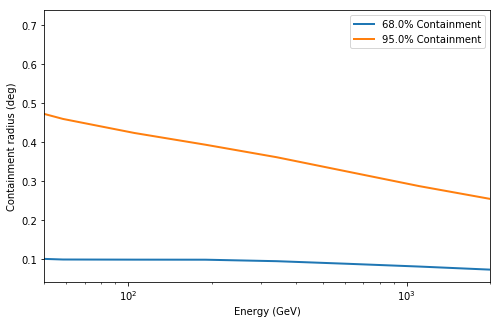

In [40]:
plt.figure(figsize=(8, 5))
psf.plot_containment_vs_energy(linewidth=2, fractions=[0.68, 0.95])
plt.xlim(50, 2000)
plt.show()

In addition we can check how the actual shape of the PSF varies with energy and compare it against the mean PSF between 50 GeV and 2000 GeV:

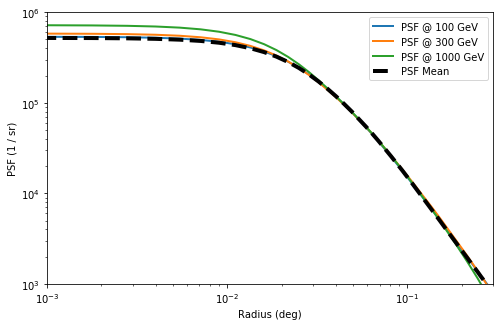

In [56]:
plt.figure(figsize=(8, 5))

for energy in [100, 300, 1000] * u.GeV:
    psf_at_energy = psf.table_psf_at_energy(energy)
    psf_at_energy.plot_psf_vs_rad(label='PSF @ {:.0f}'.format(energy), lw=2)

erange = [50, 2000] * u.GeV
psf_mean = psf.table_psf_in_energy_band(energy_band=erange, spectral_index=2.3)
psf_mean.plot_psf_vs_rad(label='PSF Mean', lw=4, c="k", ls='--')
    
plt.xlim(1e-3, 0.3)
plt.ylim(1e3, 1e6)
plt.legend()

## Estimating basic input sky images for high level analyses
Finally we'd like to use the prepared 2FHL dataset to generate a set of basic sky images, that a can be used as input for high level analyses, e.g. morphology fits, region based flux measurements, computation of significance images etc.
For this purpose Gammapy provides a convenience class called [gammapy.image.FermiLATBasicImageEstimator](http://docs.gammapy.org/dev/api/gammapy.image.FermiLATBasicImageEstimator.html). First we define a reference image, that specifies the region we'd like to analyse. In this case we choose the Vela region.

In [18]:
image_ref = SkyImage.empty(
    nxpix=360, nypix=180,
    binsz=0.05,
    xref=265, yref=0,
)

Next we choose the energy range and initialize the `FermiLATBasicImageEstimator` object:

In [19]:
emin, emax = [50, 2000] * u.GeV
image_estimator = FermiLATBasicImageEstimator(
    reference=image_ref,
    emin=emin, emax=emax,
)

Finally we run the image estimation by calling `.run()` and parsing the dataset object:

In [20]:
images_basic = image_estimator.run(dataset)

The image estimator now computes a set of sky images for the reference region and energy range we defined above. The result `images_basic` is a [gammapy.image.SkyImageList](http://docs.gammapy.org/dev/api/gammapy.image.SkyImageList.html) object containing the following images:

* **counts**: counts image containing the binned event list
* **background**: predicted number of background counts computed from the sum of the galactic and isotropic diffuse model, given the exposure.
* **exposure**: integrated exposure assuming a powerlaw with spectral index 2.3 in the given energy range
* **excess**: backround substracted counts image
* **flux**: measured flux, computed from excess divided by exposure
* **psf**: sky image of the exposure weighted mean PSF in the given energy range
    
You can check the contained images as following:

In [21]:
images_basic.names

['counts', 'background', 'exposure', 'excess', 'flux', 'psf']

To check whether the image estimation was succesfull we'll take a look at the flux image, smoothing it in advance with a Gaussian kernel of 0.2 deg:

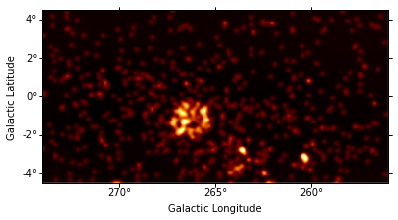

In [22]:
smoothed_flux = images_basic['flux'].smooth(
    kernel='gauss', radius=0.2 * u.deg)
smoothed_flux.show()

## Exercises

- Try to reproject the exposure using an `AIT` projection.
- Try to find the spectral index of the isotropic diffuse model using a method off the `TableModel` instance.
- Compute basic sky images for different regions (e.g. Galactic Center) and energy ranges


## What next?

In this tutorial we have learned how to access and check Fermi-LAT data.

Next you could do:
* image analysis
* spectral analysis
* cube analysis
* time analysis
* source detection